# Max of Concave Test

In [2]:
import scipy as sc
from sklearn import datasets
from matplotlib.style import available
from sklearn.cluster import KMeans
import numpy as np
import cvxpy as cp
import torch
import time
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
import mosek
warnings.filterwarnings('ignore')
plt.rcParams.update({
    "text.usetex":True,
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive","tab:blue", "tab:orange", "tab:green",
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

In [14]:
def createproblem_port(n):
    # PARAMETERS #
    A = cp.Parameter((n,n))
    b = cp.Parameter(n)
    # VARIABLES #
    # weights, s_i, lambda, tau
    x = cp.Variable(n)
    t = cp.Variable()
    tau = cp.Variable()
    gam = cp.Variable(n)
    # OBJECTIVE #
    objective = t

    # CONSTRAINTS #
    constraints = [-4*tau + 5*b@x + cp.norm(gam,2) <= t]
    constraints += [A.T@gam == 5*x]
    constraints += [t >= tau]
    constraints += [cp.sum(x) == 1]
    constraints += [x >= 0, x <= 1]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, t, tau, A, b

def normal_returns(m, N):
    R = np.vstack([np.random.normal(
        i*0.03, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())
def normal_returns1(m, N):
    R = np.vstack([np.random.normal(
        i*0.05, np.sqrt((0.01**2+(i*0.035)**2)), N) for i in range(1, m+1)])
    return (R.transpose())
def loss(x,t,tau, data,l = 1): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(-5*data@x - 4*tau, tau) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(-5*data@x - 4*tau, tau) - t, 
        torch.tensor(0.,requires_grad = True)))
                                                                                                                                                                                                                                                                                                 

In [15]:
loss(torch.tensor(5*np.ones(m)),torch.tensor(1),torch.tensor(1),val_dset)

(tensor(1., dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(1),
 tensor(0., dtype=torch.float64, grad_fn=<MeanBackward0>))

In [19]:
m = 100
N = 500
d1 = normal_returns(m,N)
d2 = normal_returns1(m,N)
data = np.concatenate((d1,d2))

In [41]:
w = 1
problem, x, t, tau, A, b = createproblem_port(m)
df1 = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
train, test = train_test_split(data, test_size=int(data.shape[0]/5), random_state=119)
val_dset = torch.tensor(train, requires_grad=True)
eval_set = torch.tensor(test, requires_grad=True)
# create cvxpylayer
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x, t, tau])

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
paramb_tch = torch.tensor(-init@np.mean(train, axis=0), requires_grad=True)
paramT_tch = torch.tensor(init, requires_grad=True)
variables = [paramT_tch, paramb_tch]
opt = torch.optim.SGD(variables, lr=0.4, momentum=0.8)
step = 50
for steps in range(step):
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l= w)
    evalloss, _, v2 = loss(*var_values, eval_set, l = w)
    totloss.backward()
    newrow = pd.Series(
        {"step": steps,
         "Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": np.linalg.norm(paramT_tch.detach().numpy().copy())
         })
    df1 = pd.concat([df1, newrow.to_frame().T], ignore_index=True)
    if steps < step - 1:
        opt.step()
        opt.zero_grad()
        
problem, x, t, tau, A, b = createproblem_port(m)
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x, t, tau])       
df2 = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
init = np.eye(m)
paramb_tch = torch.tensor(-init@np.mean(train, axis=0), requires_grad=True)
paramT_tch = torch.tensor(init, requires_grad=True)
variables = [paramT_tch, paramb_tch]
opt = torch.optim.SGD(variables, lr=0.4, momentum=0.8)
for steps in range(step):
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l=w)
    evalloss, _, v2 = loss(*var_values, eval_set, l=w)
    totloss.backward()
    newrow = pd.Series(
        {"step": steps,
         "Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": np.linalg.norm(paramT_tch.detach().numpy().copy())
         })
    df2 = pd.concat([df2, newrow.to_frame().T], ignore_index=True)
    if steps < step - 1:
        opt.step()
        opt.zero_grad()
        
problem, x, t, tau, A, b = createproblem_port(m)
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x, t, tau])  
df_eps = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
eps_tch = torch.tensor(1/1, requires_grad=True)
paramb_tch = eps_tch*torch.tensor(-np.mean(train, axis=0), requires_grad=True)
paramT_tch = eps_tch*torch.tensor(np.eye(train.shape[1]), requires_grad=True)
variables = [eps_tch]
opt = torch.optim.SGD(variables, lr=0.01, momentum=0.8)
for steps in range(step):
    paramb_tch = eps_tch*torch.tensor(-np.mean(train, axis=0), requires_grad=True)
    paramT_tch = eps_tch*torch.tensor(np.eye(train.shape[1]), requires_grad=True)
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l=w)
    evalloss, _, v2 = loss(*var_values, eval_set, l=w)
    totloss.backward()
    newrow = pd.Series(
        {"step": steps,
         "Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": eps_tch.detach().numpy().copy()
        })
    df_eps = pd.concat([df_eps, newrow.to_frame().T], ignore_index=True)
    if steps < step - 1:
        opt.step()
        opt.zero_grad()

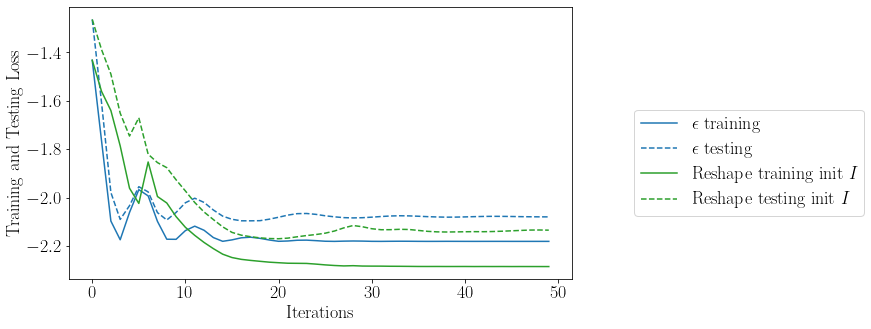

In [46]:
plt.figure(figsize=(9, 5))
plt.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
plt.plot(df_eps['step'], df_eps['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
# plt.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training init $\Sigma^{-1/2}$")
# plt.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing init $\Sigma^{-1/2}$")
plt.plot(df2['step'], df2['Loss_val'], color="tab:green", label="Reshape training init $I$")
plt.plot(df2['step'], df2['Eval_val'], linestyle='--', color="tab:green", label="Reshape testing init $I$")
plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0.2))
plt.xlabel("Iterations")
plt.ylabel("Training and Testing Loss")
plt.savefig("plot.pdf")
